In [7]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#from __future__ import division

import warnings
warnings.filterwarnings("ignore")

# import plotly.plotly as py
# import plotly.offline as pyoff
# import plotly.graph_objs as go

import tensorflow.keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# import keras
# from keras.layers import Dense
# from keras.models import Sequential
# from keras.optimizers import Adam 
# from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
# from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# #initiate plotly
# pyoff.init_notebook_mode()


In [20]:
# read csv file
import pandas as pd
df_sales = pd.read_csv('C:\\Users\\Prashant\\Dropbox (Old)\\My PC (DESKTOP-GOS3J17)\\Desktop\Sales.csv')


df_sales.head()

,date,sales
0,01-05-2017,46800
1,01-06-2017,73800
2,01-07-2017,59219
3,01-08-2017,55980
4,01-09-2017,52200


In [21]:
df_sales.shape

(37, 2)

In [22]:
# #represent month in date field as its first day
#df_sales['date'] = pd.to_datetime(df_sales['date'])
# #convert date field from string to datetime
# df_sales['date'] = pd.to_datetime(df_sales['date'])
# df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'
# df_sales['date'] = pd.to_datetime(df_sales['date'])
# #groupby date and sum the sales
# #df_sales = df_sales.groupby('date').sales.sum().reset_index()
# df_sales.head()
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    37 non-null     object
 1   sales   37 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 720.0+ bytes


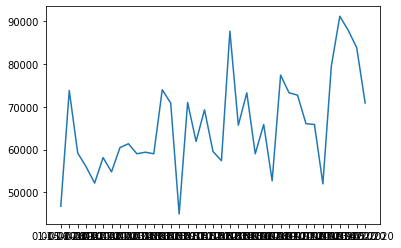

In [23]:
df=df_sales[['date','sales']]
df= df.set_index('date')

plt.plot(df)


In [25]:
df.head(1)

,sales
date,
01-05-2017,46800


In [26]:
#create a new dataframe to model the difference

df_diff = df_sales.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head(10)

,date,sales,prev_sales,diff
1,01-06-2017,73800,46800.0,27000.0
2,01-07-2017,59219,73800.0,-14581.0
3,01-08-2017,55980,59219.0,-3239.0
4,01-09-2017,52200,55980.0,-3780.0
5,01-10-2017,58140,52200.0,5940.0
6,01-11-2017,54820,58140.0,-3320.0
7,01-12-2017,60480,54820.0,5660.0
8,01-01-2018,61380,60480.0,900.0
9,01-02-2018,59040,61380.0,-2340.0
10,01-03-2018,59400,59040.0,360.0


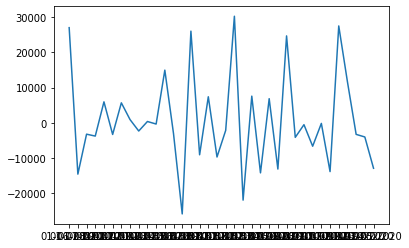

In [27]:
import seaborn as sns

plt.plot( df_diff["date"], df_diff["diff"])

In [40]:
#create dataframe for transformation from time series to supervised

df_supervised = df_diff.drop(['prev_sales'],axis=1)

#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [41]:
df_supervised.head(10)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,01-06-2018,70875,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0,-3780.0,-3239.0,-14581.0,27000.0
1,01-07-2018,45000,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0,-3780.0,-3239.0,-14581.0
2,01-08-2018,71010,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0,-3780.0,-3239.0
3,01-09-2018,61920,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0,-3780.0
4,01-10-2018,69300,7380.0,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0
5,01-11-2018,59580,-9720.0,7380.0,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0
6,01-12-2018,57420,-2160.0,-9720.0,7380.0,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0
7,01-01-2019,87660,30240.0,-2160.0,-9720.0,7380.0,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0
8,01-02-2019,65700,-21960.0,30240.0,-2160.0,-9720.0,7380.0,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0
9,01-03-2019,73260,7560.0,-21960.0,30240.0,-2160.0,-9720.0,7380.0,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0


In [42]:
df_supervised.corr()

,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
sales,1.000000,0.648581,0.037643,0.191608,-0.092001,-0.092673,-0.067723,-0.066703,0.083551,0.109048,0.013225,-0.040778,-0.098319,0.026260
diff,0.648581,1.000000,-0.484611,0.117901,-0.218721,0.006449,0.033245,-0.008483,0.118749,0.011709,-0.069426,-0.039280,-0.018962,0.060614
lag_1,0.037643,-0.484611,1.000000,-0.500861,0.104145,-0.202957,0.082179,0.012342,-0.021004,0.114750,-0.005489,-0.094400,-0.015353,0.025814
lag_2,0.191608,0.117901,-0.500861,1.000000,-0.506991,0.116441,-0.191369,0.067524,0.012862,-0.030369,0.114733,-0.009449,-0.067341,-0.035958
lag_3,-0.092001,-0.218721,0.104145,-0.506991,1.000000,-0.503140,0.150747,-0.209276,0.067694,0.005140,-0.030755,0.111223,0.017132,-0.080128
lag_4,-0.092673,0.006449,-0.202957,0.116441,-0.503140,1.000000,-0.607020,0.181529,-0.207065,0.080684,0.011287,-0.017586,0.071599,0.025770
lag_5,-0.067723,0.033245,0.082179,-0.191369,0.150747,-0.607020,1.000000,-0.580955,0.198414,-0.178827,0.094208,0.041313,-0.180375,0.154930
lag_6,-0.066703,-0.008483,0.012342,0.067524,-0.209276,0.181529,-0.580955,1.000000,-0.597227,0.186432,-0.191723,0.075496,0.106796,-0.178874
lag_7,0.083551,0.118749,-0.021004,0.012862,0.067694,-0.207065,0.198414,-0.597227,1.000000,-0.603413,0.189421,-0.188883,0.095315,0.075758
lag_8,0.109048,0.011709,0.114750,-0.030369,0.005140,0.080684,-0.178827,0.186432,-0.603413,1.000000,-0.611500,0.177204,-0.174374,0.100612


In [43]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+lag_7+lag_8+lag_9', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.31701891173988317


In [72]:
#import MinMaxScaler and create a new dataframe for LSTM model

from sklearn.preprocessing import MinMaxScaler

df_model = df_supervised.drop(['sales','date'],axis=1)

#split train and test set
train_set, test_set = df_model[0:-10].values, df_model[-10:].values

In [73]:
train_set.shape

(14, 13)

In [74]:
test_set.shape

(10, 13)

In [75]:
#apply Min Max Scaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [76]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [77]:
X_train.shape, y_train.shape

((14, 1, 12), (14, 1))

In [78]:
train_set[0]

array([ -3105.,  14940.,   -360.,    360.,  -2340.,    900.,   5660.,
        -3320.,   5940.,  -3780.,  -3239., -14581.,  27000.])

In [79]:
X_test.shape, y_test.shape

((10, 1, 12), (10, 1))

In [80]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
14/14 [==============================] - 1s 3ms/step - loss: 0.3843 
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.3840
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.3793
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3749
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.3707
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.3666
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3625
Epoch 8/100
14/14 [==============================] - 0s 4ms/step - loss: 0.3585
Epoch 9/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3546
Epoch 10/100
14/14 [==============================] - 0s 4ms/step - loss: 0.3508
Epoch 11/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3470
Epoch 12/100
14/14 [==============================] - ETA: 0s - loss: 0.008 - 0s 3ms/step - loss: 0.3432
Epoch 13/100

In [81]:
y_pred = model.predict(X_test,batch_size=1)
y_pred

array([[ 0.32818055],
       [-0.0450634 ],
       [-0.27389982],
       [ 0.10172482],
       [ 0.4947421 ],
       [ 0.31396452],
       [ 0.09963818],
       [-0.01380998],
       [ 0.00796117],
       [-0.04392901]], dtype=float32)

In [82]:
y_pred.shape

(10, 1)

In [83]:
#reshape y_pred

y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

#rebuild test set for inverse transform

pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
    
#reshape pred_test_set

pred_test_set = np.array(pred_test_set)

pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

#inverse transform

pred_test_set_inverted = scaler.inverse_transform(pred_test_set)


[[ 0.32818055  0.80112269 -0.54611067  0.1659984  -0.58460305  0.19165998
  -0.86046512  1.16305291 -0.08586297 -0.37727667  0.28187337 -0.35299219
   0.96255319]]
[[-0.0450634  -0.22534082  0.80112269 -0.54611067  0.1659984  -0.58460305
   0.19165998 -0.84908933  1.16305291 -0.08586297 -0.37727667  0.28187337
  -0.36510638]]
[[-0.27389982 -0.09703288 -0.22534082  0.80112269 -0.54611067  0.1659984
  -0.58460305  0.2888118  -0.84908933  1.16305291 -0.08586297 -0.37727667
   0.25787234]]
[[ 0.10172482 -0.31515638 -0.09703288 -0.22534082  0.80112269 -0.54611067
   0.1659984  -0.55073721  0.2888118  -0.84908933  1.16305291 -0.08586297
  -0.38893617]]
[[ 0.4947421  -0.08420209 -0.31515638 -0.09703288 -0.22534082  0.80112269
  -0.54611067  0.26105811 -0.55073721  0.2888118  -0.84908933  1.16305291
  -0.10297872]]
[[ 0.31396452 -0.57177225 -0.08420209 -0.31515638 -0.09703288 -0.22534082
   0.80112269 -0.50910668  0.26105811 -0.55073721  0.2888118  -0.84908933
   1.12255319]]
[[ 0.09963818  0.

In [84]:
y_pred.shape

(10, 1, 1)

In [85]:
pred_test_set.shape

pred_test_set.shape

(10, 13)

In [86]:
pred_test_set.shape

(10, 13)

In [89]:
#create dataframe that shows the predicted sales

result_list = []
sales_dates = list(df_sales[-11:].date)
act_sales = list(df_sales[-11:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [90]:
pred_test_set_inverted[0][0]+ act_sales[0]

88790.42582452297

In [91]:
df_result

,pred_value,date
0,88790,01-08-2019
1,74178,01-09-2019
2,67217,01-10-2019
3,71096,01-11-2019
4,81943,01-12-2019
5,63011,01-01-2020
6,84484,01-02-2020
7,92929,01-03-2020
8,90245,01-04-2020
9,84756,01-05-2020


In [92]:
df_sales_pred = pd.merge(df_sales,df_result,on='date',how='left')
#df_sales_pred

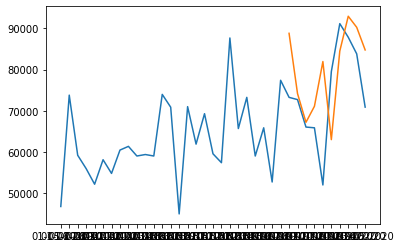

In [93]:
plt.plot(df_sales_pred["date"],df_sales_pred["sales"])
plt.plot( df_sales_pred["date"],df_sales_pred["pred_value"])

In [95]:
#df_sales_pred[-10:].pred_value

In [96]:
X_train.shape

(14, 1, 12)

In [97]:
ytrain_pred = model.predict(X_train,batch_size=1)
ytrain_pred.shape

(14, 1)

In [98]:
#reshape y_pred

ytrain_pred =ytrain_pred.reshape(ytrain_pred.shape[0], 1,ytrain_pred.shape[1])
ytrain_pred.shape
#rebuild test set for inverse transform

pred_train_set = []
for index in range(0,len(ytrain_pred)):
    print(np.concatenate([ytrain_pred[index],X_train[index]],axis=1))
    pred_train_set.append(np.concatenate([ytrain_pred[index],X_train[index]],axis=1))
    
#reshape pred_test_set

pred_train_set = np.array(pred_train_set)

pred_train_set = pred_train_set.reshape(pred_train_set.shape[0], pred_train_set.shape[2])

#inverse transform

pred_train_set_inverted = scaler.inverse_transform(pred_train_set)
pred_train_set_inverted

[[-0.45764714  0.45469126 -0.09061748 -0.06495589 -0.16118685 -0.0457097
   0.12394191 -0.13057724  0.226366   -0.14830876 -0.12745495 -0.5646526
   1.        ]]
[[-0.48765746 -0.18845229  0.45469126 -0.09061748 -0.06495589 -0.16118685
  -0.0457097   0.2155729  -0.13057724  0.226366   -0.14830876 -0.12745495
  -0.57280378]]
[[ 0.55021727 -1.         -0.18845229  0.45469126 -0.09061748 -0.06495589
  -0.16118685  0.0320902   0.2155729  -0.13057724  0.226366   -0.14830876
  -0.14379196]]
[[-0.29886624  0.84923817 -1.         -0.18845229  0.45469126 -0.09061748
  -0.06495589 -0.09280139  0.0320902   0.2155729  -0.13057724  0.226366
  -0.16425532]]
[[ 0.18231802 -0.40176423  0.84923817 -1.         -0.18845229  0.45469126
  -0.09061748  0.01127493 -0.09280139  0.0320902   0.2155729  -0.13057724
   0.20340426]]
[[-0.42803469  0.18524459 -0.40176423  0.84923817 -1.         -0.18845229
   0.45469126 -0.01647875  0.01127493 -0.09280139  0.0320902   0.2155729
  -0.14685579]]
[[-0.06625389 -0.4242

array([[-10657.93476507,  14940.        ,   -360.        ,
           360.        ,  -2340.        ,    900.        ,
          5660.        ,  -3320.        ,   5940.        ,
         -3780.        ,  -3239.        , -14581.        ,
         27000.        ],
       [-11499.94911633,  -3105.        ,  14940.        ,
          -360.        ,    360.        ,  -2340.        ,
           900.        ,   5660.        ,  -3320.        ,
          5940.        ,  -3780.        ,  -3239.        ,
        -14581.        ],
       [ 17620.22107691, -25875.        ,  -3105.        ,
         14940.        ,   -360.        ,    360.        ,
         -2340.        ,    900.        ,   5660.        ,
         -3320.        ,   5940.        ,  -3780.        ,
         -3239.        ],
       [ -6202.93958969,  26010.        , -25875.        ,
         -3105.        ,  14940.        ,   -360.        ,
           360.        ,  -2340.        ,    900.        ,
          5660.        ,  -3320.     

In [99]:
ytrain_pred.shape

(14, 1, 1)

In [100]:
pred_train_set.shape

(14, 13)

In [101]:
pred_train_set_inverted.shape

(14, 13)

In [102]:
df_supervised.head(7)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,01-06-2018,70875,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0,-3780.0,-3239.0,-14581.0,27000.0
1,01-07-2018,45000,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0,-3780.0,-3239.0,-14581.0
2,01-08-2018,71010,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0,-3780.0,-3239.0
3,01-09-2018,61920,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0,-3780.0
4,01-10-2018,69300,7380.0,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0,5940.0
5,01-11-2018,59580,-9720.0,7380.0,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0,-3320.0
6,01-12-2018,57420,-2160.0,-9720.0,7380.0,-9090.0,26010.0,-25875.0,-3105.0,14940.0,-360.0,360.0,-2340.0,900.0,5660.0


In [103]:
529117+1452.25587544

530569.25587544

In [104]:
#create dataframe that shows the predicted sales

result_list = []
sales_dates = list(df_supervised.iloc[0:14].date)
act_sales = list(df_supervised.iloc[0:14].sales)
for index in range(0,len(sales_dates)):
    result_dict = {}
    #print(pred_train_set_inverted[index][0])
    result_dict['pred_value'] = int(pred_train_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index]
    result_list.append(result_dict)
df_result1 = pd.DataFrame(result_list)

In [105]:
df_result1

,pred_value,date
0,60217,01-06-2018
1,33500,01-07-2018
2,88630,01-08-2018
3,55717,01-09-2018
4,76597,01-10-2018
5,49752,01-11-2018
6,57743,01-12-2018
7,112495,01-01-2019
8,46155,01-02-2019
9,83203,01-03-2019


###### sales_dates = list(df_supervised.iloc[0:1].date)
sales_dates

In [106]:
act_sales = list(df_supervised.iloc[0:1].sales)
act_sales

[70875]

In [108]:
#list(df_sales.iloc[0:41].date)

In [109]:
#list(df_sales.iloc[0:41].sales)

In [110]:
#df_result1

In [111]:
#df_sales.iloc[0:41].sales

In [112]:
pred_train_set_inverted= pd.DataFrame(pred_train_set_inverted)
pred_train_set_inverted.shape

(14, 13)

In [114]:
import math
# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(t, trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))

from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(df_supervised.iloc[0:14].sales,pred_train_set_inverted[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 65085.35 RMSE


In [115]:


testScore = math.sqrt(mean_squared_error(df_sales_pred[-6:].sales,df_sales_pred[-6:].pred_value))
print('Test Score: %.2f RMSE' % (testScore))



Test Score: 15658.83 RMSE


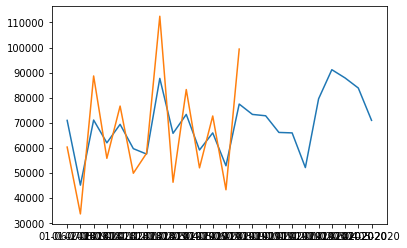

In [116]:
plt.plot(df_supervised["date"],df_supervised["sales"])
plt.plot( df_result1["date"],df_result1["pred_value"])